# Model Walkthrough — Weather Transformer from Scratch

This notebook walks through each component of the Weather Transformer, explaining the theory and testing each piece individually.

## Contents
1. [Patch Embedding](#1-patch-embedding)
2. [Positional Encoding](#2-positional-encoding)
3. [Multi-Head Self-Attention](#3-multi-head-self-attention)
4. [Transformer Block](#4-transformer-block)
5. [Full Weather Transformer](#5-full-weather-transformer)
6. [Physics-Informed Loss](#6-physics-informed-loss)

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Test dimensions
B = 2        # Batch size
C = 4        # Channels (weather variables)
H, W = 32, 64  # Spatial dimensions (lat, lon)
PATCH_SIZE = 4
EMBED_DIM = 256
NUM_HEADS = 8

Using device: cuda


---

## 1. Patch Embedding

### Theory

The Patch Embedding layer converts a 2D weather grid into a sequence of tokens that the transformer can process.

**Steps:**
1. Split the input `(B, C, H, W)` into non-overlapping patches of size `P×P`
2. Flatten each patch and project to embedding dimension

**Implementation:** We use `nn.Conv2d` with `kernel_size=patch_size` and `stride=patch_size` — this elegantly handles both the patch extraction AND linear projection in one operation.

```
Input:  (B, 4, 32, 64)  →  4 variables on 32×64 grid
Output: (B, 128, 256)   →  128 patch tokens, each 256-dim
```

In [2]:
from src.models.patch_embedding import PatchEmbedding

# Create patch embedding layer
patch_embed = PatchEmbedding(
    in_channels=C,
    embed_dim=EMBED_DIM,
    patch_size=PATCH_SIZE,
    img_height=H,
    img_width=W,
)

# Test input
x = torch.randn(B, C, H, W)
print(f"Input shape:  {x.shape}")

# Forward pass
patches = patch_embed(x)
print(f"Output shape: {patches.shape}")
print(f"Number of patches: {patch_embed.n_patches}")
print(f"Patch grid: {patch_embed.n_patches_h} × {patch_embed.n_patches_w}")

Input shape:  torch.Size([2, 4, 32, 64])
Output shape: torch.Size([2, 128, 256])
Number of patches: 128
Patch grid: 8 × 16


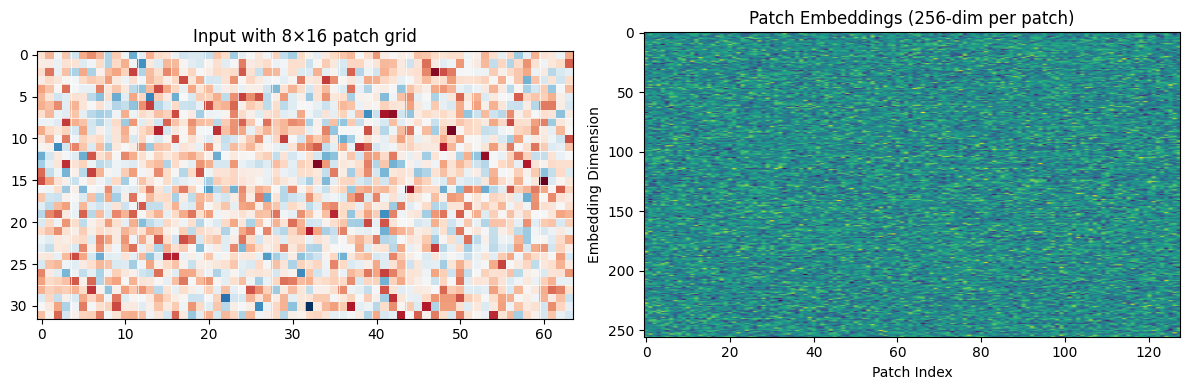

In [3]:
# Visualize patch grid
n_h, n_w = patch_embed.n_patches_h, patch_embed.n_patches_w

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Original image with patch grid
ax1.imshow(x[0, 0].numpy(), cmap='RdBu_r')
for i in range(n_h + 1):
    ax1.axhline(i * PATCH_SIZE - 0.5, color='white', linewidth=0.5)
for j in range(n_w + 1):
    ax1.axvline(j * PATCH_SIZE - 0.5, color='white', linewidth=0.5)
ax1.set_title(f"Input with {n_h}×{n_w} patch grid")

# Embedding visualization
ax2.imshow(patches[0].detach().numpy().T, aspect='auto', cmap='viridis')
ax2.set_xlabel("Patch Index")
ax2.set_ylabel("Embedding Dimension")
ax2.set_title("Patch Embeddings (256-dim per patch)")

plt.tight_layout()
plt.show()

---

## 2. Positional Encoding

### Theory

Transformers have no inherent notion of position — they see a "bag of tokens". Positional encoding adds spatial information.

**Two variants:**

1. **Learnable** (like ViT): Each position gets a learned embedding vector
2. **Sinusoidal** (like original Transformer): Fixed sin/cos patterns at different frequencies

We use **2D sinusoidal encoding** that separately encodes latitude and longitude positions.

In [4]:
from src.models.positional_encoding import (
    LearnablePositionalEncoding,
    SinusoidalPositionalEncoding,
)

N_PATCHES = patch_embed.n_patches

# Learnable
learnable_pe = LearnablePositionalEncoding(
    n_patches=N_PATCHES,
    embed_dim=EMBED_DIM,
    dropout=0.0,
)

# Sinusoidal
sinusoidal_pe = SinusoidalPositionalEncoding(
    n_patches=N_PATCHES,
    embed_dim=EMBED_DIM,
    n_patches_h=n_h,
    n_patches_w=n_w,
    dropout=0.0,
)

# Apply both
out_learn = learnable_pe(patches)
out_sin = sinusoidal_pe(patches)

print(f"After positional encoding: {out_learn.shape}")

After positional encoding: torch.Size([2, 128, 256])


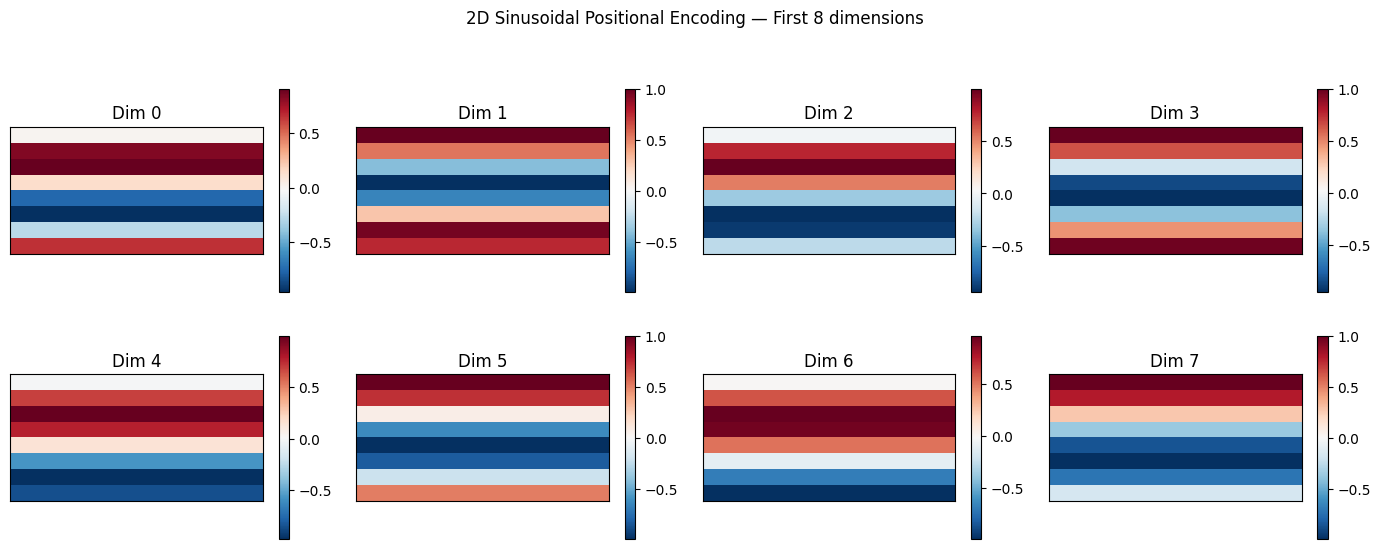

In [5]:
# Visualize sinusoidal positional encodings
pe = sinusoidal_pe.position_embeddings[0].numpy()  # (N, D)
pe_2d = pe.reshape(n_h, n_w, EMBED_DIM)

fig, axes = plt.subplots(2, 4, figsize=(14, 6))
fig.suptitle("2D Sinusoidal Positional Encoding — First 8 dimensions", fontsize=12)

for i, ax in enumerate(axes.flat):
    im = ax.imshow(pe_2d[:, :, i], cmap='RdBu_r')
    ax.set_title(f"Dim {i}")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(im, ax=ax, shrink=0.7)

plt.tight_layout()
plt.show()

---

## 3. Multi-Head Self-Attention

### Theory

Self-attention allows each token to "look at" every other token and aggregate information based on learned relevance.

**Formula:**
```
Attention(Q, K, V) = softmax(Q @ K.T / sqrt(d_k)) @ V
```

**Multi-head:** We run `num_heads` parallel attention operations, each with a subset of the embedding dimensions, then concatenate.

**Key insight:** We implement this from scratch — no `nn.MultiheadAttention`!

In [6]:
from src.models.attention import MultiHeadSelfAttention

# Create attention layer
attention = MultiHeadSelfAttention(
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    dropout=0.0,
)

# Apply attention
x_embedded = out_sin  # Use output from positional encoding
attn_out, attn_weights = attention(x_embedded, return_attention=True)

print(f"Attention output: {attn_out.shape}")
print(f"Attention weights: {attn_weights.shape}")
print(f"  → (batch, num_heads, seq_len, seq_len)")

Attention output: torch.Size([2, 128, 256])
Attention weights: torch.Size([2, 8, 128, 128])
  → (batch, num_heads, seq_len, seq_len)


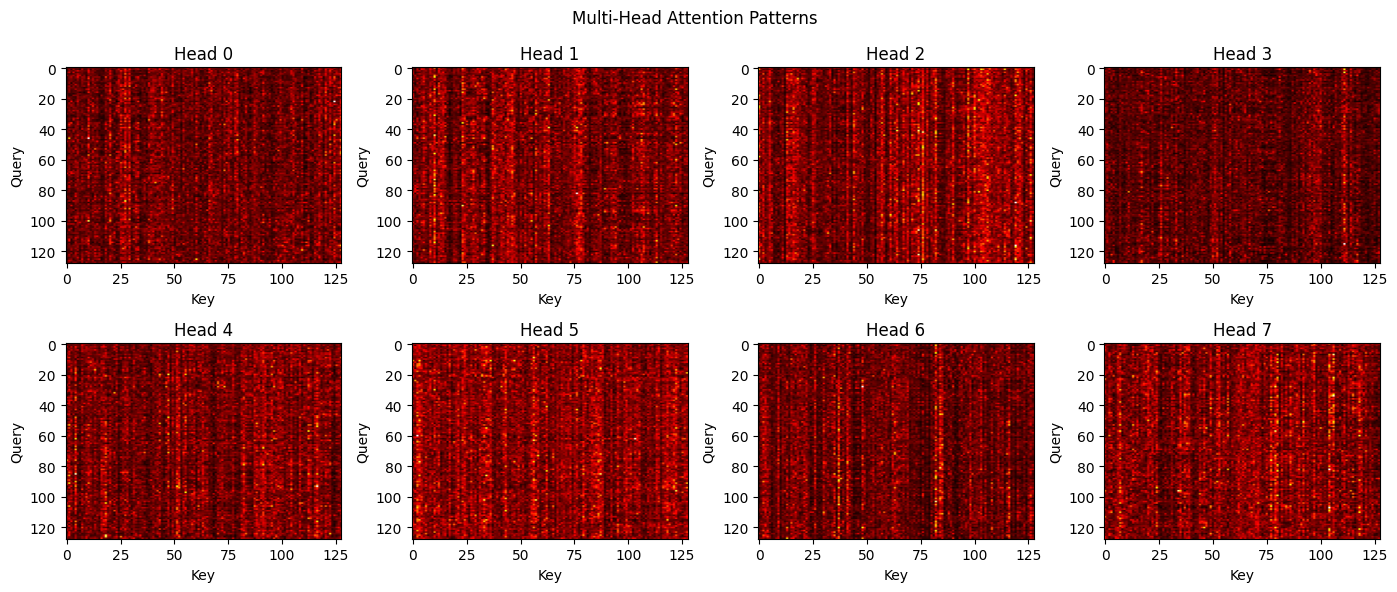

In [7]:
# Visualize attention patterns
attn = attn_weights[0].detach().numpy()  # (num_heads, N, N)

fig, axes = plt.subplots(2, 4, figsize=(14, 6))
fig.suptitle("Multi-Head Attention Patterns", fontsize=12)

for head_idx, ax in enumerate(axes.flat):
    im = ax.imshow(attn[head_idx], cmap='hot', aspect='auto')
    ax.set_title(f"Head {head_idx}")
    ax.set_xlabel("Key")
    ax.set_ylabel("Query")

plt.tight_layout()
plt.show()

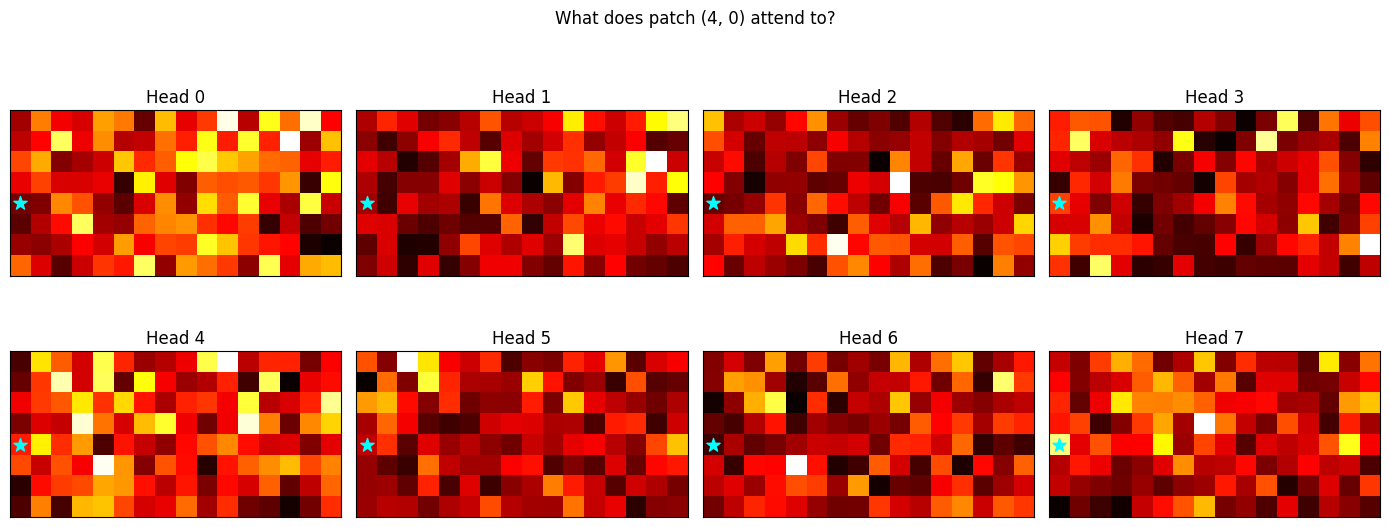

In [8]:
# Visualize what a specific patch attends to
query_patch = N_PATCHES // 2  # Center patch
query_h, query_w = query_patch // n_w, query_patch % n_w

fig, axes = plt.subplots(2, 4, figsize=(14, 6))
fig.suptitle(f"What does patch ({query_h}, {query_w}) attend to?", fontsize=12)

for head_idx, ax in enumerate(axes.flat):
    attn_map = attn[head_idx, query_patch].reshape(n_h, n_w)
    im = ax.imshow(attn_map, cmap='hot')
    ax.scatter([query_w], [query_h], c='cyan', s=100, marker='*')
    ax.set_title(f"Head {head_idx}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

---

## 4. Transformer Block

### Theory

A transformer block combines:
1. **Layer Norm** → **Multi-Head Attention** → **Residual**
2. **Layer Norm** → **MLP (Feed-Forward)** → **Residual**

We use **Pre-Norm** architecture (LayerNorm before each sublayer) — more stable training.

```
x → LayerNorm → MHSA → + → LayerNorm → MLP → + → output
     └─────────────────┘    └───────────────┘
          residual              residual
```

In [9]:
from src.models.transformer_block import TransformerBlock

# Create transformer block
block = TransformerBlock(
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    mlp_ratio=4.0,
    dropout=0.0,
)

# Apply block
block_out, block_attn = block(x_embedded, return_attention=True)

print(f"Block output: {block_out.shape}")
print(f"Residual connection preserved shape ✓")

Block output: torch.Size([2, 128, 256])
Residual connection preserved shape ✓


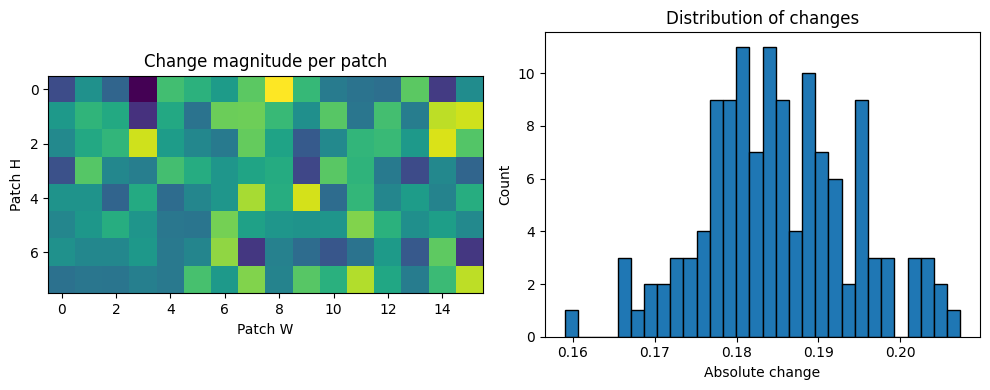

In [10]:
# Show the information flow — how much does the output differ from input?
diff = (block_out - x_embedded).abs().mean(dim=-1)[0].detach().numpy()  # (N,)
diff_2d = diff.reshape(n_h, n_w)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.imshow(diff_2d, cmap='viridis')
ax1.set_title("Change magnitude per patch")
ax1.set_xlabel("Patch W")
ax1.set_ylabel("Patch H")

ax2.hist(diff.flatten(), bins=30, edgecolor='black')
ax2.set_title("Distribution of changes")
ax2.set_xlabel("Absolute change")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()

---

## 5. Full Weather Transformer

### Theory

Now we stack everything together:

1. **Patch Embedding** — Grid to tokens
2. **Positional Encoding** — Add spatial info
3. **N × Transformer Blocks** — Learn cross-patch relationships
4. **Prediction Head** — Tokens back to grid

The model predicts the **next weather state** (t+6h) given the current state (t).

In [11]:
from src.models.weather_transformer import WeatherTransformer

# Create full model
model = WeatherTransformer(
    in_channels=C,
    out_channels=C,
    img_height=H,
    img_width=W,
    patch_size=PATCH_SIZE,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_layers=6,
    mlp_ratio=4.0,
    dropout=0.0,
)

print("Model Configuration:")
for k, v in model.get_config().items():
    print(f"  {k}: {v}")

Model Configuration:
  in_channels: 4
  out_channels: 4
  img_height: 32
  img_width: 64
  patch_size: 4
  embed_dim: 256
  num_layers: 6
  n_patches: 128
  total_params: 4805440


In [12]:
# Forward pass
x = torch.randn(B, C, H, W)
output, all_attentions = model(x, return_attention=True)

print(f"Input:  {x.shape}")
print(f"Output: {output.shape}")
print(f"Attention weights from {len(all_attentions)} layers")

Input:  torch.Size([2, 4, 32, 64])
Output: torch.Size([2, 4, 32, 64])
Attention weights from 6 layers


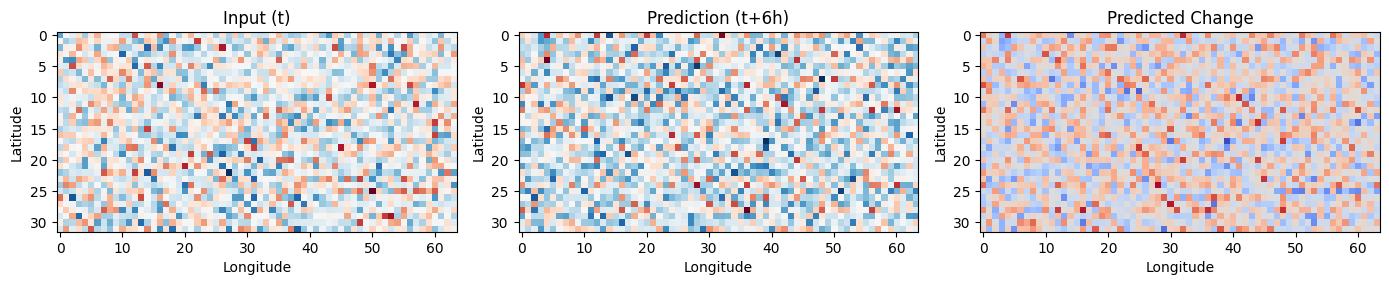

In [13]:
# Visualize prediction
var_idx = 0  # First variable

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].imshow(x[0, var_idx].numpy(), cmap='RdBu_r')
axes[0].set_title("Input (t)")

axes[1].imshow(output[0, var_idx].detach().numpy(), cmap='RdBu_r')
axes[1].set_title("Prediction (t+6h)")

diff = (output[0, var_idx] - x[0, var_idx]).detach().numpy()
axes[2].imshow(diff, cmap='coolwarm')
axes[2].set_title("Predicted Change")

for ax in axes:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

---

## 6. Physics-Informed Loss

### Theory

Standard MSE loss only penalizes pixel-wise errors. We add physics-based constraints:

**Total Loss = α×MSE + β×Smoothness + γ×Conservation**

1. **MSE** — Standard reconstruction loss
2. **Smoothness** — Penalizes unrealistic sharp gradients (weather fields should be smooth)
3. **Conservation** — Global mean should not change drastically (energy conservation proxy)

In [14]:
from src.models.physics_loss import (
    PhysicsInformedLoss,
    SpatialSmoothnessLoss,
    ConservationLoss,
)

# Create loss function
loss_fn = PhysicsInformedLoss(
    mse_weight=1.0,
    smoothness_weight=0.1,
    conservation_weight=0.05,
)

# Compute loss
target = x + torch.randn_like(x) * 0.3  # Synthetic target
losses = loss_fn(output, target)

print("Loss Components:")
for k, v in losses.items():
    print(f"  {k}: {v.item():.6f}")

Loss Components:
  total: 3.398082
  mse: 2.701781
  smoothness: 6.933825
  conservation: 0.058381


In [15]:
# Demonstrate smoothness loss behavior
smooth = torch.ones(1, 4, 32, 64)  # Perfectly smooth
noisy = torch.randn(1, 4, 32, 64)  # Random noise

smooth_loss = SpatialSmoothnessLoss()
print(f"Smoothness loss (uniform field): {smooth_loss(smooth).item():.6f}")
print(f"Smoothness loss (random noise):  {smooth_loss(noisy).item():.6f}")
print("→ Noisy inputs get penalized more ✓")

Smoothness loss (uniform field): 0.000000
Smoothness loss (random noise):  4.058950
→ Noisy inputs get penalized more ✓


In [16]:
# Demonstrate conservation loss behavior
conservation_loss = ConservationLoss()

pred_same_mean = torch.randn(1, 4, 32, 64)
target_same_mean = pred_same_mean.clone()  # Same mean
target_diff_mean = pred_same_mean + 5.0     # Different mean

print(f"Conservation loss (same mean):      {conservation_loss(pred_same_mean, target_same_mean).item():.6f}")
print(f"Conservation loss (different mean): {conservation_loss(pred_same_mean, target_diff_mean).item():.6f}")
print("→ Mean-preserving predictions are preferred ✓")

Conservation loss (same mean):      0.000000
Conservation loss (different mean): 25.000002
→ Mean-preserving predictions are preferred ✓


---

## Summary

We've built a complete Weather Transformer from scratch:

| Component | Purpose | Key Insight |
|-----------|---------|-------------|
| **Patch Embedding** | Tokenize 2D grid | Conv2d with stride=patch_size |
| **Positional Encoding** | Add spatial info | 2D sinusoidal for lat/lon |
| **Multi-Head Attention** | Cross-patch relationships | Parallel attention heads |
| **Transformer Block** | Process tokens | Pre-norm + residuals |
| **Physics Loss** | Realistic predictions | Smoothness + conservation |

**Next steps:**
- Train on real ERA5 data
- Evaluate against persistence baseline
- Visualize learned attention patterns